## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
import os

# save the model on Google Drive, link Google drive to this notebook
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
%cd /content/gdrive/'My Drive'/'Colab Notebooks'/'ud-facial-keypoints'
%ls

/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints
'1. Load and Visualize Data.ipynb'
'1. Load and Visualize Data-zh.ipynb'
'2. Define the Network Architecture.html'
'2. Define the Network Architecture.ipynb'
'2. Define the Network Architecture-zh.ipynb'
'3. Facial Keypoint Detection, Complete Pipeline.html'
'3. Facial Keypoint Detection, Complete Pipeline.ipynb'
'3. Facial Keypoint Detection, Complete Pipeline-zh.ipynb'
'4. Fun with Keypoints.html'
'4. Fun with Keypoints.ipynb'
'4. Fun with Keypoints-zh.ipynb'
'5. Zip Your Project Files and Submit.ipynb'
'5. Zip Your Project Files and Submit-zh.ipynb'
 data_load.py
 detector_architectures/
 filelist.txt
 filtered_image.jpeg
 gitignore.txt
 images/
 models.py
 project1.zip
 __pycache__/
 workspace_utils.py


In [10]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-28 19:08:34--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.241.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.241.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  29.9MB/s    in 37s     

2019-10-28 19:09:11 (8.78 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import cv2

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [12]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, Net2, Net3, Net4, Net5

net = Net4()
print(net)

Net4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=80000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [15]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

## splitting training data into train and validation data (not yet implemented)

In [0]:
#print(torch.__version__)
#train_size = int(0.8 * len(transformed_dataset))
#test_size = len(transformed_dataset) - train_size
# raises an attribute error because it torch.utils.data.random_split requires Pytorch 1.1.0
#train_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])

In [0]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)    # was 4


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [0]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [21]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/ud-facial-keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

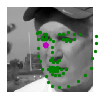

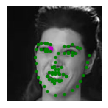

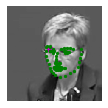

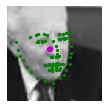

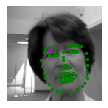

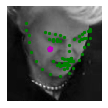

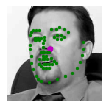

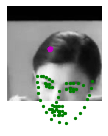

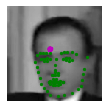

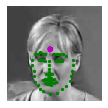

In [23]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

# moved the definition of loss function and optimizer to train_net()


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [0]:
model_dir = 'saved_models/'


In [0]:
def train_net(n_epochs, model):

    net = model
    # prepare the net for training
    net.train()
    
    #criterion = nn.MSELoss()
    criterion = nn.SmoothL1Loss()

    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    #optimizer = torch.optim.SGD(params, lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=True)

    
    

    
    training_loss = []
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
        training_loss.append(running_loss)
        #torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
    print('Finished Training')
    return (net,training_loss)

In [0]:
# Use this cell for creating a new instance after changes to the model architecture
from models import Net, Net2, Net3, Net4, Net5

#net = Net()
#net = Net2()
#net = Net3()
net = Net4()
#net = Net5()

In [0]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    net, training_loss = train_net(n_epochs, net)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.13796981424093246
Epoch: 1, Batch: 20, Avg. Loss: 0.103481125831604
Epoch: 1, Batch: 30, Avg. Loss: 0.0850602276623249
Epoch: 1, Batch: 40, Avg. Loss: 0.09315932355821133
Epoch: 1, Batch: 50, Avg. Loss: 0.09122995659708977
Epoch: 1, Batch: 60, Avg. Loss: 0.08503608740866184
Epoch: 1, Batch: 70, Avg. Loss: 0.09777390733361244
Epoch: 1, Batch: 80, Avg. Loss: 0.09685406498610974
Epoch: 1, Batch: 90, Avg. Loss: 0.09083880670368671
Epoch: 1, Batch: 100, Avg. Loss: 0.10936495438218116
Epoch: 1, Batch: 110, Avg. Loss: 0.09677601121366024
Epoch: 1, Batch: 120, Avg. Loss: 0.10129158273339271
Epoch: 1, Batch: 130, Avg. Loss: 0.07736489400267602
Epoch: 1, Batch: 140, Avg. Loss: 0.08219398222863675
Epoch: 1, Batch: 150, Avg. Loss: 0.08851604834198952
Epoch: 1, Batch: 160, Avg. Loss: 0.09247940853238105
Epoch: 1, Batch: 170, Avg. Loss: 0.06962416805326939
Epoch: 1, Batch: 180, Avg. Loss: 0.07611141949892045
Epoch: 1, Batch: 190, Avg. Loss: 0.08548986501991748
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.07733414284884929
Epoch: 2, Batch: 20, Avg. Loss: 0.07066540345549584
Epoch: 2, Batch: 30, Avg. Loss: 0.05734044350683689
Epoch: 2, Batch: 40, Avg. Loss: 0.07242940664291382
Epoch: 2, Batch: 50, Avg. Loss: 0.07979044616222382
Epoch: 2, Batch: 60, Avg. Loss: 0.06198223046958447
Epoch: 2, Batch: 70, Avg. Loss: 0.05690844934433699
Epoch: 2, Batch: 80, Avg. Loss: 0.06099347360432148
Epoch: 2, Batch: 90, Avg. Loss: 0.05310252085328102
Epoch: 2, Batch: 100, Avg. Loss: 0.08983470760285854
Epoch: 2, Batch: 110, Avg. Loss: 0.05794881097972393
Epoch: 2, Batch: 120, Avg. Loss: 0.061348415724933145
Epoch: 2, Batch: 130, Avg. Loss: 0.07820540182292461
Epoch: 2, Batch: 140, Avg. Loss: 0.061384117603302
Epoch: 2, Batch: 150, Avg. Loss: 0.07096956837922334
Epoch: 2, Batch: 160, Avg. Loss: 0.10236392505466937
Epoch: 2, Batch: 170, Avg. Loss: 0.0617473004385829
Epoch: 2, Batch: 180, Avg. Loss: 0.05402791928499937
Epoch: 2, Batch: 190, Avg. Loss: 0.07103107050061226
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.08105695396661758
Epoch: 3, Batch: 20, Avg. Loss: 0.06743639577180147
Epoch: 3, Batch: 30, Avg. Loss: 0.06105294562876225
Epoch: 3, Batch: 40, Avg. Loss: 0.04924970678985119
Epoch: 3, Batch: 50, Avg. Loss: 0.060166477039456365
Epoch: 3, Batch: 60, Avg. Loss: 0.08667312040925026
Epoch: 3, Batch: 70, Avg. Loss: 0.06923071071505546
Epoch: 3, Batch: 80, Avg. Loss: 0.052768392488360405
Epoch: 3, Batch: 90, Avg. Loss: 0.09804675318300723
Epoch: 3, Batch: 100, Avg. Loss: 0.06261357385665178
Epoch: 3, Batch: 110, Avg. Loss: 0.057980988174676895
Epoch: 3, Batch: 120, Avg. Loss: 0.05763994660228491
Epoch: 3, Batch: 130, Avg. Loss: 0.06553557552397252
Epoch: 3, Batch: 140, Avg. Loss: 0.059352664090692994
Epoch: 3, Batch: 150, Avg. Loss: 0.051950891874730586
Epoch: 3, Batch: 160, Avg. Loss: 0.05344426184892655
Epoch: 3, Batch: 170, Avg. Loss: 0.05484657064080238
Epoch: 3, Batch: 180, Avg. Loss: 0.0721028545871377
Epoch: 3, Batch: 190, Avg. Loss: 0.0603390038013458

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.054873026907444
Epoch: 4, Batch: 20, Avg. Loss: 0.05504312887787819
Epoch: 4, Batch: 30, Avg. Loss: 0.034085204266011714
Epoch: 4, Batch: 40, Avg. Loss: 0.0443414943292737
Epoch: 4, Batch: 50, Avg. Loss: 0.04787091761827469
Epoch: 4, Batch: 60, Avg. Loss: 0.05456644464284181
Epoch: 4, Batch: 70, Avg. Loss: 0.06086657252162695
Epoch: 4, Batch: 80, Avg. Loss: 0.046790351159870625
Epoch: 4, Batch: 90, Avg. Loss: 0.043319798074662685
Epoch: 4, Batch: 100, Avg. Loss: 0.04023075737059116
Epoch: 4, Batch: 110, Avg. Loss: 0.031001937948167323
Epoch: 4, Batch: 120, Avg. Loss: 0.043892692774534225
Epoch: 4, Batch: 130, Avg. Loss: 0.046523194387555124
Epoch: 4, Batch: 140, Avg. Loss: 0.06772842053323984
Epoch: 4, Batch: 150, Avg. Loss: 0.03801308684051037
Epoch: 4, Batch: 160, Avg. Loss: 0.038070270977914336
Epoch: 4, Batch: 170, Avg. Loss: 0.03915958441793919
Epoch: 4, Batch: 180, Avg. Loss: 0.02981004249304533
Epoch: 4, Batch: 190, Avg. Loss: 0.044223777577281


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.03282695962116122
Epoch: 5, Batch: 20, Avg. Loss: 0.03285852987319231
Epoch: 5, Batch: 30, Avg. Loss: 0.04342066086828709
Epoch: 5, Batch: 40, Avg. Loss: 0.037704925425350665
Epoch: 5, Batch: 50, Avg. Loss: 0.03234567791223526
Epoch: 5, Batch: 60, Avg. Loss: 0.027808098308742046
Epoch: 5, Batch: 70, Avg. Loss: 0.03927491698414087
Epoch: 5, Batch: 80, Avg. Loss: 0.035871184431016445
Epoch: 5, Batch: 90, Avg. Loss: 0.045760943181812765
Epoch: 5, Batch: 100, Avg. Loss: 0.035543867573142054
Epoch: 5, Batch: 110, Avg. Loss: 0.024204684887081385
Epoch: 5, Batch: 120, Avg. Loss: 0.05598123986274004
Epoch: 5, Batch: 130, Avg. Loss: 0.034745737072080375
Epoch: 5, Batch: 140, Avg. Loss: 0.02594887437298894
Epoch: 5, Batch: 150, Avg. Loss: 0.035862533003091814
Epoch: 5, Batch: 160, Avg. Loss: 0.03117456119507551
Epoch: 5, Batch: 170, Avg. Loss: 0.03452389100566507
Epoch: 5, Batch: 180, Avg. Loss: 0.023943341989070176
Epoch: 5, Batch: 190, Avg. Loss: 0.02496729651

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.039070305228233335
Epoch: 6, Batch: 20, Avg. Loss: 0.030095227900892495
Epoch: 6, Batch: 30, Avg. Loss: 0.023146197386085986
Epoch: 6, Batch: 40, Avg. Loss: 0.02493204465135932
Epoch: 6, Batch: 50, Avg. Loss: 0.03736847583204508
Epoch: 6, Batch: 60, Avg. Loss: 0.04037927594035864
Epoch: 6, Batch: 70, Avg. Loss: 0.038440166227519515
Epoch: 6, Batch: 80, Avg. Loss: 0.016516098473221063
Epoch: 6, Batch: 90, Avg. Loss: 0.029638940189033746
Epoch: 6, Batch: 100, Avg. Loss: 0.06330280285328627
Epoch: 6, Batch: 110, Avg. Loss: 0.02842085137963295
Epoch: 6, Batch: 120, Avg. Loss: 0.02650126600638032
Epoch: 6, Batch: 130, Avg. Loss: 0.022602353990077973
Epoch: 6, Batch: 140, Avg. Loss: 0.022421184182167053
Epoch: 6, Batch: 150, Avg. Loss: 0.027884393557906152
Epoch: 6, Batch: 160, Avg. Loss: 0.03803998176008463
Epoch: 6, Batch: 170, Avg. Loss: 0.02215522825717926
Epoch: 6, Batch: 180, Avg. Loss: 0.02765761883929372
Epoch: 6, Batch: 190, Avg. Loss: 0.02789829839

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.02788453921675682
Epoch: 7, Batch: 20, Avg. Loss: 0.031043307669460774
Epoch: 7, Batch: 30, Avg. Loss: 0.015637517813593148
Epoch: 7, Batch: 40, Avg. Loss: 0.027193712908774613
Epoch: 7, Batch: 50, Avg. Loss: 0.023551491647958757
Epoch: 7, Batch: 60, Avg. Loss: 0.02745028892531991
Epoch: 7, Batch: 70, Avg. Loss: 0.02931488286703825
Epoch: 7, Batch: 80, Avg. Loss: 0.026187041867524387
Epoch: 7, Batch: 90, Avg. Loss: 0.034963305294513705
Epoch: 7, Batch: 100, Avg. Loss: 0.023459534533321856
Epoch: 7, Batch: 110, Avg. Loss: 0.02514027189463377
Epoch: 7, Batch: 120, Avg. Loss: 0.018188245687633754
Epoch: 7, Batch: 130, Avg. Loss: 0.02525977501645684
Epoch: 7, Batch: 140, Avg. Loss: 0.021592859458178282
Epoch: 7, Batch: 150, Avg. Loss: 0.021304020192474127
Epoch: 7, Batch: 160, Avg. Loss: 0.024365424551069735
Epoch: 7, Batch: 170, Avg. Loss: 0.051934390887618066
Epoch: 7, Batch: 180, Avg. Loss: 0.040135439950972795
Epoch: 7, Batch: 190, Avg. Loss: 0.0255094

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.015215559117496013
Epoch: 8, Batch: 20, Avg. Loss: 0.031623698957264426
Epoch: 8, Batch: 30, Avg. Loss: 0.031124228704720737
Epoch: 8, Batch: 40, Avg. Loss: 0.02635351289063692
Epoch: 8, Batch: 50, Avg. Loss: 0.018070820439606904
Epoch: 8, Batch: 60, Avg. Loss: 0.03529050573706627
Epoch: 8, Batch: 70, Avg. Loss: 0.025119872111827136
Epoch: 8, Batch: 80, Avg. Loss: 0.024204094987362625
Epoch: 8, Batch: 90, Avg. Loss: 0.02778707668185234
Epoch: 8, Batch: 100, Avg. Loss: 0.026465272810310126
Epoch: 8, Batch: 110, Avg. Loss: 0.022902879863977432
Epoch: 8, Batch: 120, Avg. Loss: 0.01837529195472598
Epoch: 8, Batch: 130, Avg. Loss: 0.022017397824674843
Epoch: 8, Batch: 140, Avg. Loss: 0.023136046854779123
Epoch: 8, Batch: 150, Avg. Loss: 0.018863252270966767
Epoch: 8, Batch: 160, Avg. Loss: 0.017570015182718633
Epoch: 8, Batch: 170, Avg. Loss: 0.014380565192550421
Epoch: 8, Batch: 180, Avg. Loss: 0.02312272982671857
Epoch: 8, Batch: 190, Avg. Loss: 0.0245947

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0220200901851058
Epoch: 9, Batch: 20, Avg. Loss: 0.02573742065578699
Epoch: 9, Batch: 30, Avg. Loss: 0.01780682587996125
Epoch: 9, Batch: 40, Avg. Loss: 0.01790359141305089
Epoch: 9, Batch: 50, Avg. Loss: 0.017794947046786545
Epoch: 9, Batch: 60, Avg. Loss: 0.02215137127786875
Epoch: 9, Batch: 70, Avg. Loss: 0.017471636272966863
Epoch: 9, Batch: 80, Avg. Loss: 0.019387969747185707
Epoch: 9, Batch: 90, Avg. Loss: 0.01979324989952147
Epoch: 9, Batch: 100, Avg. Loss: 0.01934054559096694
Epoch: 9, Batch: 110, Avg. Loss: 0.025629338808357716
Epoch: 9, Batch: 120, Avg. Loss: 0.023232254851609468
Epoch: 9, Batch: 130, Avg. Loss: 0.02129088444635272
Epoch: 9, Batch: 140, Avg. Loss: 0.014879590924829244
Epoch: 9, Batch: 150, Avg. Loss: 0.014642209745943546
Epoch: 9, Batch: 160, Avg. Loss: 0.023716998193413018
Epoch: 9, Batch: 170, Avg. Loss: 0.025637956336140633
Epoch: 9, Batch: 180, Avg. Loss: 0.01674084719270468
Epoch: 9, Batch: 190, Avg. Loss: 0.013183011580

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.021549547649919988
Epoch: 10, Batch: 20, Avg. Loss: 0.02657066285610199
Epoch: 10, Batch: 30, Avg. Loss: 0.014670280646532774
Epoch: 10, Batch: 40, Avg. Loss: 0.016167077189311384
Epoch: 10, Batch: 50, Avg. Loss: 0.03046410484239459
Epoch: 10, Batch: 60, Avg. Loss: 0.017901331605389714
Epoch: 10, Batch: 70, Avg. Loss: 0.023127511981874703
Epoch: 10, Batch: 80, Avg. Loss: 0.0212412029504776
Epoch: 10, Batch: 90, Avg. Loss: 0.02030772026628256
Epoch: 10, Batch: 100, Avg. Loss: 0.01683693556115031
Epoch: 10, Batch: 110, Avg. Loss: 0.015173542685806752
Epoch: 10, Batch: 120, Avg. Loss: 0.017759113013744353
Epoch: 10, Batch: 130, Avg. Loss: 0.02324514724314213
Epoch: 10, Batch: 140, Avg. Loss: 0.02112856591120362
Epoch: 10, Batch: 150, Avg. Loss: 0.017358378786593676
Epoch: 10, Batch: 160, Avg. Loss: 0.023202158324420453
Epoch: 10, Batch: 170, Avg. Loss: 0.017281168699264528
Epoch: 10, Batch: 180, Avg. Loss: 0.016589918918907643
Epoch: 10, Batch: 190, Avg.

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [0]:
## TODO: change the name to something uniqe for each new model

model_name = 'keypoints_model_net4_v1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [0]:
# reload model with the best model architecture
net = Net4()
net.load_state_dict(torch.load('saved_models/keypoints_model_net4_v1.pt'))

In [0]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


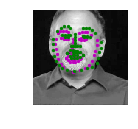

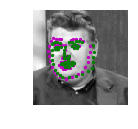

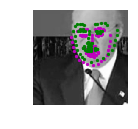

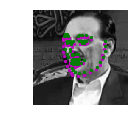

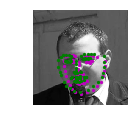

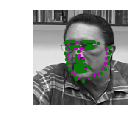

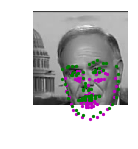

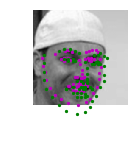

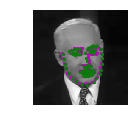

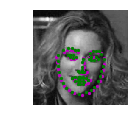

In [0]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: The problem is a regression problem, so the basic choice was between MSE or SmoothL1Loss. I tried both loss functions and I have chosen SmoothL1Loss because it works better on noisy data due to it's smoothing ability.
For the optimizer Adam and SGD+Nesterow are considered as good default optimizers so I tried both of them. Adam provided better results for the limited number of epochs that the model was trained on.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The basic architecture was inspired by NaimishNet with an additional 5th convolutional layer + maxpooling to adapt to the bigger input size of 224 x 224. I also changed all the kernels for the convolutions to odd kernel sizes that are used by many network architectures. I experimented with several layer architectures and for the limited number of epochs the simples model with only 3 convolutional layers and 3 fully-connected layers provided the best results. Adding a dropout layer to the first fully-connected layer did not improve the results because the model did not overfit on the small number of epochs, but it might be beneficial when training for longer epochs.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I tried to increase the batch size from 10 to 16 but I ran into memory errors, even though I tried to reduce the number of workers. Working on the Udacity workspace without GPU did not leave many options for tweaking this parameter, though a higher batch rate might be helpful to smooth out the noise in the dataset. I restricted training to 10 epochs due to experienced workspace freezing and crashed kernels. An effective training of the model on the supplied computing resources is not possible, but it was a good learning experience on how to train on limited resoucres. I am looking forward to run this code on GPU and start to finetune the hyperparameters.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.09133738  0.17081477 -0.15487024  0.01993142 -0.09914246]
 [ 0.13125692  0.06309278  0.03903531  0.0996571  -0.13597412]
 [ 0.209299    0.19180816 -0.20554668  0.10512644 -0.24088745]
 [ 0.07519803  0.14914009 -0.154057   -0.17910615  0.08239169]
 [ 0.04475877 -0.19820713 -0.10498682 -0.10710824 -0.05649827]]
(5, 5)


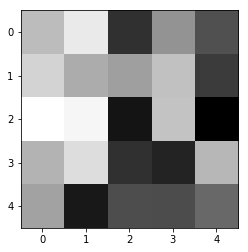

In [0]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 1
filter_conv1 = w[filter_index][0]
print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

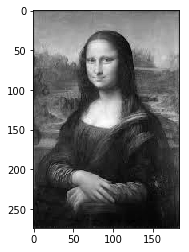

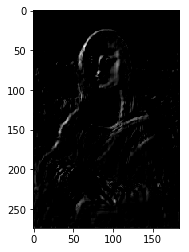

In [0]:
##TODO: load in and display any image from the transformed test dataset
image = cv2.imread('images/mona_lisa.jpg')  
image_copy = np.copy(image)
image_RGB = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.show()

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
filtered_image = cv2.filter2D(image_gray, -1, filter_conv1)
plt.imshow(filtered_image, cmap='gray')

In [0]:
from PIL import Image
im = Image.fromarray(image)
im.save("filtered_image.jpeg")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It detects vertical edges where the image changes from bright to dark.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!